# Object detector for detection on images_14

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

from tqdm import tqdm

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

In [4]:
MODEL_NAME = 'inference_graph_14'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training_14/labelmap.pbtxt'

In [5]:
PATH_TO_FROZEN_GRAPH

'inference_graph_14/frozen_inference_graph.pb'

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [7]:
detection_graph

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [9]:
category_index

{1: {'id': 1, 'name': 'Glomeruli'}}

# Detection

In [10]:
# This is needed to display the images.
%matplotlib inline

In [11]:
IMAGE_SIZE = (12, 8)

In [12]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [13]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [14]:
import pandas as pd
ground_truth=pd.read_csv("C:/Users/jashj/Desktop/Tensorflow/models/research/object_detection/images_14/test_images_labels.csv")

In [61]:
import cv2
imgname="38.jpg"
# imgname=name_list[i]
image_path = "C:/Users/jashj/Desktop/Tensorflow/models/research/object_detection/images_14/test_images/"+imgname
image = Image.open(image_path)
image_np = load_image_into_numpy_array(image)

In [62]:
# image_path = "C:/Users/jashj/Desktop/RA/Human Annotation Analysis using QuPath/Comparison Data/V8/O 7200_8200.jpg"
# image = Image.open(image_path)
# image_np = load_image_into_numpy_array(image)

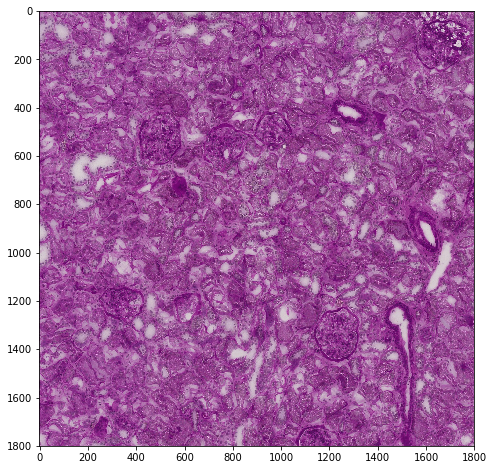

In [63]:
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

In [64]:
image_np_expanded = np.expand_dims(image_np, axis=0)

In [65]:
# Get handles to input and output tensors
ops = tf.get_default_graph().get_operations()
all_tensor_names = {output.name for op in ops for output in op.outputs}
tensor_dict = {}
for key in [
  'num_detections', 'detection_boxes', 'detection_scores',
  'detection_classes', 'detection_masks']:
    tensor_name = key + ':0'
    if tensor_name in all_tensor_names:
        tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)

In [66]:
output_dict = run_inference_for_single_image(image_np, detection_graph)

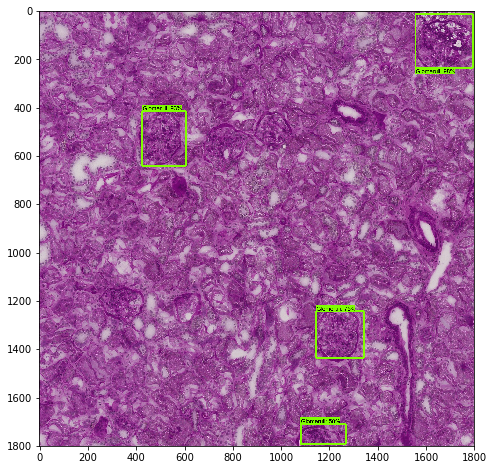

In [67]:
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  output_dict['detection_boxes'],
  output_dict['detection_classes'],
  output_dict['detection_scores'],
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  min_score_thresh=0.50,
  line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)


In [68]:
# cv2.imwrite('F 6200_7200',image_np)

## These block just picks the above image and draws the actual and predicted boxes

In [73]:
import pandas as pd
ground_truth=pd.read_csv("C:/Users/jashj/Desktop/Tensorflow/models/research/object_detection/images_14/test_images_labels.csv")

In [70]:
t=ground_truth[ground_truth['filename'] == imgname]


In [71]:
for k in range(t.shape[0]):
    box1=np.array([t['xmin'][t.index[k]],t['ymin'][t.index[k]],t['xmax'][t.index[k]],t['ymax'][t.index[k]]])
    x1,y1,x2,y2 =[t['xmin'][t.index[k]],t['ymin'][t.index[k]],t['xmax'][t.index[k]],t['ymax'][t.index[k]]]
    cv2.rectangle(image_np, (x1, y1), (x2, y2), (255,0,0), 2)    

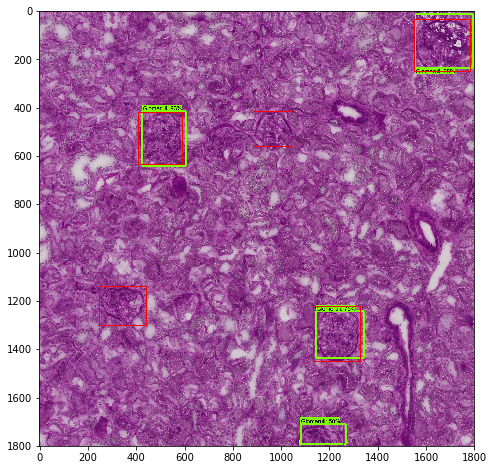

In [72]:
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)
plt.imsave(imgname[:-4]+' output'+imgname[-4:],image_np)

# Accuracy metrics

In [37]:
def iou(box1, box2):
    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2
    
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    
    inter_width = (xi2-xi1)
    inter_height = (yi2-yi1)
    
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    
    inter_area = max(inter_width,0)*max(inter_height,0)  
    
    union_area = box1_area+box2_area-inter_area
        
    return inter_area/union_area

In [38]:
dir="C:/Users/jashj/Desktop/Tensorflow/models/research/object_detection/images_14/test_images"
import os
import cv2

name_list=[]
files=os.listdir(dir)
name_list=[i for i in files if i.endswith('.jpg')]

In [40]:
comparison=ground_truth.groupby('filename')['filename'].agg(['count'])

In [41]:
comparison['predicted']=0
comparison['predicted in IOU']=0

In [42]:
comparison['true_positive']=0
comparison['false_positive']=0
comparison['predicted_groundtruth']=0
comparison['notpredicted_groundtruth']=0

In [43]:
comparison.head()

,count,predicted,predicted in IOU,true_positive,false_positive,predicted_groundtruth,notpredicted_groundtruth
filename,,,,,,,
19.jpg,2,0,0,0,0,0,0
20.jpg,2,0,0,0,0,0,0
25.jpg,5,0,0,0,0,0,0
26.jpg,1,0,0,0,0,0,0
28.jpg,6,0,0,0,0,0,0


In [44]:
name_list

['19.jpg',
 '20.jpg',
 '25.jpg',
 '26.jpg',
 '28.jpg',
 '29.jpg',
 '30.jpg',
 '31.jpg',
 '32.jpg',
 '33.jpg',
 '34.jpg',
 '35.jpg',
 '36.jpg',
 '37.jpg',
 '38.jpg',
 '39.jpg',
 '40.jpg',
 '41.jpg',
 '42.jpg',
 '43.jpg',
 '44.jpg',
 '45.jpg',
 '46.jpg',
 '47.jpg',
 '48.jpg',
 '49.jpg',
 '50.jpg',
 '51.jpg',
 '52.jpg',
 '53.jpg',
 '55.jpg',
 '57.jpg',
 '58.jpg',
 '59.jpg',
 '60.jpg',
 '61.jpg',
 '62.jpg']

In [45]:
ious,ids=[],[]
temp2=[]
box_list=[]

img_dict={}

metrics={'false_positive':[]
        ,'true_positive':[]
         ,'predicted_groundtruth':[]
         ,'notpredicted_groundtruth':[]
        }


for img_name in tqdm(name_list[:]):
    
    img_dict[img_name]={'false_positive':[]
        ,'true_positive':[]
        ,'predicted_groundtruth':[]
        ,'notpredicted_groundtruth':[]
        }
    
    count_predicted=0
    image_path = os.path.join(dir,img_name)
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    tensor_dict = {}
    for key in [
      'num_detections', 'detection_boxes', 'detection_scores',
      'detection_classes', 'detection_masks']:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    
#     vis_util.visualize_boxes_and_labels_on_image_array(
#       image_np,
#       output_dict['detection_boxes'],
#       output_dict['detection_classes'],
#       output_dict['detection_scores'],
#       category_index,
#       instance_masks=output_dict.get('detection_masks'),
#       use_normalized_coordinates=True,
#       min_score_thresh=0.50,
#       line_thickness=8)
#     plt.figure(figsize=IMAGE_SIZE)
#     plt.imshow(image_np)
    
    final_score = np.squeeze(output_dict['detection_scores']) 
    
    boxes=[]
    for i in range(300):
        if output_dict['detection_scores'] is None or final_score[i] > 0.50:
                count_predicted = count_predicted + 1
                boxes.append(list(output_dict['detection_boxes'][i]))
                
    comparison.predicted[img_name]=count_predicted
                
                
                
                
    
    
#     boxes = output_dict['detection_boxes']
    
    temp=ground_truth[ground_truth['filename'] == img_name]
    ground_truth_actual=[]
    
    for z in range(temp.shape[0]):
            box1=np.array([temp['xmin'][temp.index[z]],temp['ymin'][temp.index[z]],temp['xmax'][temp.index[z]],temp['ymax'][temp.index[z]]])
            ground_truth_actual.append(list(box1))
    
    temp1=[]
    boxes_actual=[]
    for j in range(len(boxes)):
        ymin, xmin, ymax, xmax=boxes[j]
#         xmin, ymin, xmax, ymax=boxes[j]
        box2=np.array([xmin*1800,ymin*1800,xmax*1800,ymax*1800])
        boxes_actual.append([xmin*1800,ymin*1800,xmax*1800,ymax*1800])
#         box_list.append((i,box2))
#         for k in range(temp.shape[0]):
#             box1=np.array([temp['xmin'][temp.index[k]],temp['ymin'][temp.index[k]],temp['xmax'][temp.index[k]],temp['ymax'][temp.index[k]]])

        for k in range(len(ground_truth_actual)):
            box1=np.array(ground_truth_actual[k])




#             x1,y1,x2,y2 =[t['xmin'][t.index[k]],t['ymin'][t.index[k]],t['xmax'][t.index[k]],t['ymax'][t.index[k]]]          
#             cv2.rectangle(image_np, (x1, y1), (x2, y2), (255,0,0), 2)
            
            iou_val=iou(box2,box1)
            
            if iou_val>=0.5:
                temp1.append(iou_val)
                img_dict[img_name]['true_positive'].append(list(box2))
                img_dict[img_name]['predicted_groundtruth'].append(list(box1))
#     ious.append(sum(temp1)/len(temp1))
    
#     plt.figure(figsize=IMAGE_SIZE)
#     plt.imshow(image_np)
#     plt.imsave(img_name[:-4]+' output'+img_name[-4:],image_np)
    
    img_dict[img_name]['false_positive']=[x for x in boxes_actual if x not in img_dict[img_name]['true_positive']]
    img_dict[img_name]['notpredicted_groundtruth']=[x for x in ground_truth_actual if x not in img_dict[img_name]['predicted_groundtruth']]
    temp2.append(temp1)
    comparison['predicted in IOU'][img_name]=len(temp1)
    comparison['true_positive'][img_name]=len(img_dict[img_name]['true_positive'])
    comparison['false_positive'][img_name]=len(img_dict[img_name]['false_positive'])
    comparison['predicted_groundtruth'][img_name]=len(img_dict[img_name]['predicted_groundtruth'])
    comparison['notpredicted_groundtruth'][img_name]=len(img_dict[img_name]['notpredicted_groundtruth'])
    
    

100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [04:59<00:00,  8.10s/it]


In [46]:
comparison

,count,predicted,predicted in IOU,true_positive,false_positive,predicted_groundtruth,notpredicted_groundtruth
filename,,,,,,,
19.jpg,2,2,1,1,1,1,1
20.jpg,2,2,1,1,1,1,1
25.jpg,5,6,5,5,1,5,0
26.jpg,1,0,0,0,0,0,1
28.jpg,6,3,3,3,0,3,3
29.jpg,3,1,1,1,0,1,2
30.jpg,6,4,4,4,0,4,2
31.jpg,5,5,5,5,0,5,0
32.jpg,5,5,4,4,1,4,1


In [47]:
comparison['precision']=comparison['predicted in IOU']/comparison['predicted']
comparison['recall']=comparison['predicted in IOU']/comparison['count']

In [56]:
comparison.round(3)

,count,predicted,predicted in IOU,true_positive,false_positive,predicted_groundtruth,notpredicted_groundtruth,precision,recall
filename,,,,,,,,,
19.jpg,2,2,1,1,1,1,1,0.500,0.500
20.jpg,2,2,1,1,1,1,1,0.500,0.500
25.jpg,5,6,5,5,1,5,0,0.833,1.000
26.jpg,1,0,0,0,0,0,1,NaN,0.000
28.jpg,6,3,3,3,0,3,3,1.000,0.500
29.jpg,3,1,1,1,0,1,2,1.000,0.333
30.jpg,6,4,4,4,0,4,2,1.000,0.667
31.jpg,5,5,5,5,0,5,0,1.000,1.000
32.jpg,5,5,4,4,1,4,1,0.800,0.800
